In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101

from tensorflow.keras import layers, Model


In [18]:
def model_def(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),  # Layer input dengan 50 neuron
        tf.keras.layers.Dense(50, activation='relu'),  
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    return model

def model_dropout1(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(input_shape,), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def residual_block(input_tensor, filters):
    x = tf.keras.layers.Dense(filters, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(filters, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Shortcut connection
    shortcut = tf.keras.layers.Dense(filters)(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    # Tambahkan shortcut ke output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet_tabular(input_shape):

    # Membuat model ResNet untuk data Iris
    input_shape = input_shape

    inputs = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((input_shape, 1))(inputs)  # Menambahkan dimensi untuk keperluan Conv1D

    x = residual_block(x, 64)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer dengan 3 kelas (Iris memiliki 3 kelas)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


def set_callbacks(model_name):
    callbacks = [
    # Early stopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi setelah beberapa epoch
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # ModelCheckpoint untuk menyimpan model dengan akurasi validasi terbaik
    ModelCheckpoint(f'{model_name}.h5', monitor='val_accuracy', save_best_only=True)
    ]
    return callbacks

def resnet_buPima(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)  # Tambahkan layer input
    x = tf.expand_dims(inputs, axis=-1)  # Tambahkan dimensi keempat

    resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None)
    resnet_50.trainable = False

    x = resnet_50(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten(name="flatten")(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def model_resnetBuPim(input_shape):
  model = resnet_buPima(input_shape)
  return model

In [19]:
lda = LinearDiscriminantAnalysis()

In [20]:
tes_df = pd.read_csv(f'./dataset/dogcat-encode/encoded-dogcat-img-32.csv')
tes_df = tes_df.iloc[:,1:]
tes_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,0.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
tes_df = tes_df.loc[:, (tes_df != 0).any(axis=0)]
tes_df.head()

,33,34,35,36,37,38,39,40,41,42,...,982,983,984,985,986,987,988,989,990,0.1
0,-0.966520,-0.919650,1.274014,1.308275,0.603212,-0.052970,-1.005349,1.348194,-1.390473,1.333687,...,1.305409,0.786403,-1.352538,-0.129257,-0.060674,-0.189630,-0.237056,-0.156641,-0.216891,0
1,1.030498,0.607565,0.622076,-0.095764,-0.069185,-0.052970,0.003309,0.034313,0.991686,0.808348,...,-1.655486,1.213451,1.170142,1.012661,1.084871,0.991861,0.943416,-0.055117,-1.501210,0
2,-0.043921,-0.058439,1.033827,1.236883,1.182864,1.311154,1.332904,0.674692,0.669461,-0.041136,...,1.016541,0.977451,1.003445,1.024313,-1.433058,-0.921029,1.280693,1.208301,-1.455748,0
3,1.357495,1.147257,-0.967738,0.618154,0.580026,-0.899667,-0.088387,-1.367895,-1.252377,-1.192411,...,0.234191,0.775165,-0.785769,-1.224567,-1.240244,-1.404878,0.257618,0.644275,1.317472,0
4,1.322460,-0.127335,-1.436676,0.047020,0.672770,-1.605248,0.828575,-1.069788,0.151601,-1.360072,...,0.041612,-1.472457,-1.330312,-0.863348,-0.037989,-0.189630,-0.237056,-1.420059,-0.898830,0


In [24]:
df = pd.read_csv(f'./dataset/dogcat-encode/encoded-dogcat-img-32.csv')
df = df.iloc[:,1:]
# df = df.loc[:, (df != 0).any(axis=0)]

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]

X_lda = lda.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

c:\ProgramData\anaconda3\envs\mdl\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


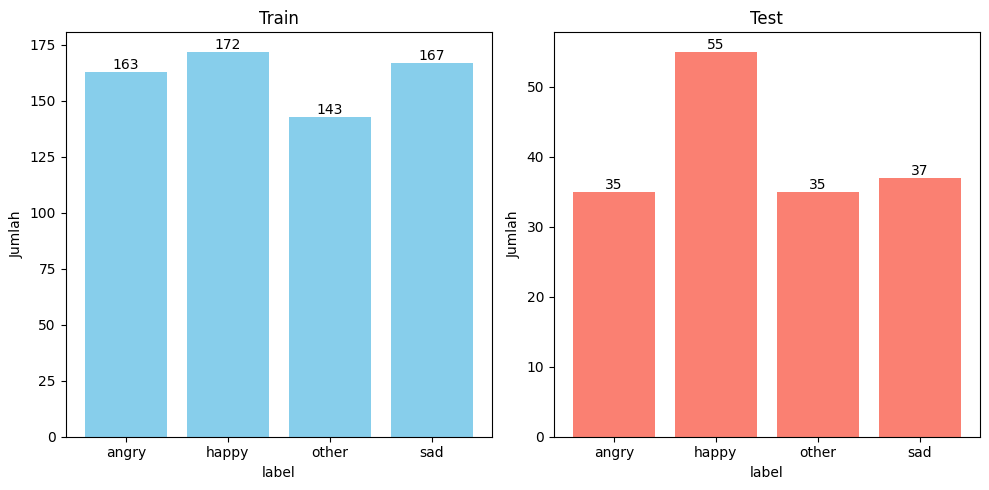

In [30]:
label_map = {
    0: "angry",
    1: "happy",
    2: "other",
    3: "sad"
}

label_train = pd.DataFrame()
label_test = pd.DataFrame()
# Menghitung jumlah label untuk setiap nilai unik dalam kolom 'label' pada df_train dan df_test
label_train['0.1'] = y_train['0.1'].map(label_map).fillna(y_train['0.1'])
label_test['0.1'] = y_test['0.1'].map(label_map).fillna(y_test['0.1'])

train_label_counts = label_train.groupby('0.1').size()
test_label_counts = label_test .groupby('0.1').size()

# Data train dan test
data = [train_label_counts, test_label_counts]
titles = ['Train', 'Test']
colors = ['skyblue', 'salmon']

# Menyiapkan subplots dalam satu canvas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, (label, counts) in enumerate(zip(['y_train', 'y_test'], data)):
    bars = ax[i].bar(counts.index, counts, color=colors[i])
    ax[i].set_xlabel('label')
    ax[i].set_ylabel('Jumlah')
    ax[i].set_title(titles[i])
    
    # Menambahkan label pada setiap bar
    for bar in bars:
        yval = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
model_default = model_def(X_train.shape[1])
model_dropout = model_dropout1(X_train.shape[1])
model_resnet = resnet_tabular(X_train.shape[1])
# model_buPima = model_resnetBuPim(X_train.shape[1])

models = [model_default, model_dropout, model_resnet]
model_names = ['default', 'dropout1', 'resnet']
# models = [model_default, model_dropout, model_resnet, model_buPima]
# model_names = ['default', 'dropout1', 'resnet', 'resnet bu Pima']
# print(models[0])
X_train.shape[1]

3

In [31]:
accuracies = []
histories = []


for i, model in enumerate(models):
    # Compile model
    models[i].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=set_callbacks(model_names[i]))
    histories.append(history)

    last_accuracy = history.history['val_accuracy'][-1]  # Mengambil akurasi validasi terakhir
    accuracies.append(last_accuracy)

Epoch 1/50
21/21 [==============================] - 2s 21ms/step - loss: 0.6956 - accuracy: 0.7969 - val_loss: 0.2989 - val_accuracy: 1.0000
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1764 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 1.0000
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 1.0000
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 1.0000
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 8/50
21/21 [=

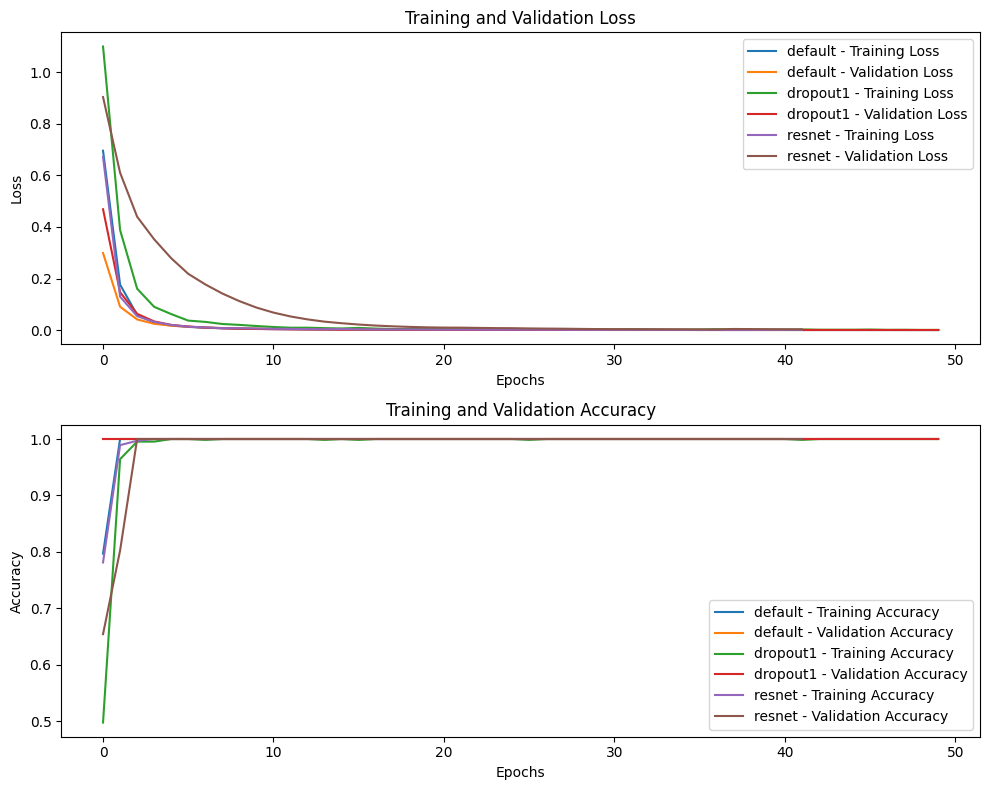

In [32]:
# Plot loss
plt.figure(figsize=(10, 8))
for i, history in enumerate(histories):
    plt.subplot(2, 1, 1)  # Dua baris, satu kolom, plot pertama
    plt.plot(history.history['loss'], label=f'{model_names[i]} - Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

# Plot akurasi
for i, history in enumerate(histories):
    plt.subplot(2, 1, 2)  # Dua baris, satu kolom, plot kedua
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [33]:
res = pd.DataFrame({
    'dataset_source': model_names,
    'accuracy' : accuracies
})

res.head()

,dataset_source,accuracy
0,default,1.0
1,dropout1,1.0
2,resnet,1.0
